In [64]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import re

# Download dataset

In [23]:
BASE_PATH = '/content/drive/MyDrive/BS6207/Assignment/'

In [24]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='artifacts':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
              image.append(c)
              labels.append('artifacts')
    if file=='cancer':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
              image.append(c)
              labels.append('cancer')
    if file=='normal':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
              image.append(c)
              labels.append('normal')
    if file=='others':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
              image.append(c)
              labels.append('others')
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data

,Images,labels
0,14252.png,artifacts
1,3733.png,artifacts
2,14848.png,artifacts
3,3290.png,artifacts
4,5626.png,artifacts
...,...,...
6924,2719.png,others
6925,1996.png,others
6926,14911.png,others
6927,14495.png,others


In [25]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [26]:
test_data= data.groupby(['labels']).head(100)
test_data['labels'].value_counts()

artifacts    100
normal       100
cancer       100
others       100
Name: labels, dtype: int64

In [27]:
left_data = pd.concat([data,test_data]).drop_duplicates(keep=False).reset_index(drop=True)
left_data['labels'].value_counts()

cancer       2778
artifacts    2280
normal       1087
others        384
Name: labels, dtype: int64

# Parameter tune

In [28]:
first_try = left_data.groupby(['labels']).head(100)
first_try = first_try.sample(frac=1).reset_index(drop=True)

In [29]:
batch_size = 20
validation_split = .3
shuffle_dataset = True
random_seed= 42

## Split data

In [30]:
dataset_size = len(first_try)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [31]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Normalize data

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [33]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((128,128))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [34]:
train_dataset = Arthopod_Dataset(first_try,BASE_PATH,transform)
test_dataset = Arthopod_Dataset(test_data,BASE_PATH,transform)

In [35]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## CNN building

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm2(self.pool(x))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, 64*4*4) # Flatten layer
        x = self.fc1(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        # x = self.dropout(x)
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [37]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [38]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

## Training

In [42]:
def train_model(n_epochs,lr,w_decay,model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay = w_decay,)
  print_every = 10
  valid_loss_min = np.Inf
  val_loss = []
  val_acc = [0]
  train_loss = []
  train_acc = []
  total_step = len(train_loader)
  for epoch in range(1, n_epochs+1):
      running_loss = 0.0
      # scheduler.step(epoch)
      correct = 0
      total=0
      for batch_idx, (data_, target_) in enumerate(train_loader):
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = model(data_)
          loss = criterion(outputs, target_)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          _,pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred==target_).item()
          total += target_.size(0)
          if (batch_idx) % 20 == 0:
              print ('------------Epoch [{}/{}]----------- Loss: {:.4f}' 
                    .format(epoch, n_epochs, loss.item()))
      train_acc.append(100 * correct / total)
      train_loss.append(running_loss/total_step)
      print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
      batch_loss = 0
      total_t=0
      correct_t=0
      with torch.no_grad():
          model.eval()
          for data_t, target_t in (validation_loader):
              #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
              outputs_t = model(data_t)
              loss_t = criterion(outputs_t, target_t)
              batch_loss += loss_t.item()
              _,pred_t = torch.max(outputs_t, dim=1)
              correct_t += torch.sum(pred_t==target_t).item()
              total_t += target_t.size(0)
          if (100 * correct_t / total_t) == val_acc[-1]:
            return train_acc,val_acc
          val_acc.append(100 * correct_t / total_t)
          val_loss.append(batch_loss/len(validation_loader))
          network_learned = batch_loss < valid_loss_min
          print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
      model.train()
  return train_acc,val_acc

# Train without image augmentation

In [ ]:
train_size = []

In [65]:
test_acc = []
for i in range(10,300,10):
  # correponding to train size  = 40-1200
  criterion = nn.CrossEntropyLoss()
  batch_size = int((i * 4) * 0.3 // 10)
  cur_train = left_data.groupby(['labels']).head(i)
  cur_train = cur_train.sample(frac=1).reset_index(drop=True)
  train_dataset = Arthopod_Dataset(cur_train,BASE_PATH,transform)
  test_dataset = Arthopod_Dataset(test_data,BASE_PATH,transform)
  dataset_size = len(cur_train)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                            sampler=train_sampler)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                  sampler=valid_sampler)
  

  model = Net()
  train_acc,val_acc = train_model(10,0.001,0,model)
  total_t=0
  correct_t=0
  for batch_idx, (data_t, target_t) in enumerate(train_loader):
    outputs_t = model(data_t)
    loss_t = criterion(outputs_t, target_t)
    _,pred_t = torch.max(outputs_t, dim=1)
    correct_t += torch.sum(pred_t==target_t).item()
    total_t += target_t.size(0)
  test_acc.append((100 * correct_t / total_t))

------------Epoch [1/10]----------- Loss: 1.5804
------------Epoch [1/10]----------- Loss: 1.4289

train loss: 2.0317, train acc: 25.0000
validation loss: 1.3996, validation acc: 8.3333

------------Epoch [2/10]----------- Loss: 0.0300
------------Epoch [2/10]----------- Loss: 0.0000

train loss: 1.1156, train acc: 92.8571
validation loss: 1.5331, validation acc: 33.3333

------------Epoch [3/10]----------- Loss: 0.0036
------------Epoch [3/10]----------- Loss: 0.0001

train loss: 0.7476, train acc: 100.0000
validation loss: 1.5722, validation acc: 25.0000

------------Epoch [4/10]----------- Loss: 0.0000
------------Epoch [4/10]----------- Loss: 0.0002

train loss: 0.5623, train acc: 100.0000
validation loss: 1.5978, validation acc: 33.3333

------------Epoch [5/10]----------- Loss: 0.0000
------------Epoch [5/10]----------- Loss: 0.0000

train loss: 0.4508, train acc: 100.0000
------------Epoch [1/10]----------- Loss: 1.2097
------------Epoch [1/10]----------- Loss: 4.6867

train los

KeyboardInterrupt: ignored

In [49]:
test_acc

[75.0,
 92.85714285714286,
 46.42857142857143,
 96.42857142857143,
 89.28571428571429,
 47.61904761904762,
 96.42857142857143,
 47.32142857142857,
 97.22222222222223,
 97.5,
 24.025974025974026,
 97.61904761904762,
 33.51648351648352,
 94.89795918367346,
 51.904761904761905,
 97.54464285714286,
 49.15966386554622,
 98.21428571428571,
 47.36842105263158,
 52.32142857142857,
 95.40816326530613,
 98.05194805194805,
 97.04968944099379,
 48.80952380952381,
 97.57142857142857,
 96.84065934065934,
 48.94179894179894,
 96.5561224489796,
 98.15270935960591]

No handles with labels found to put in legend.


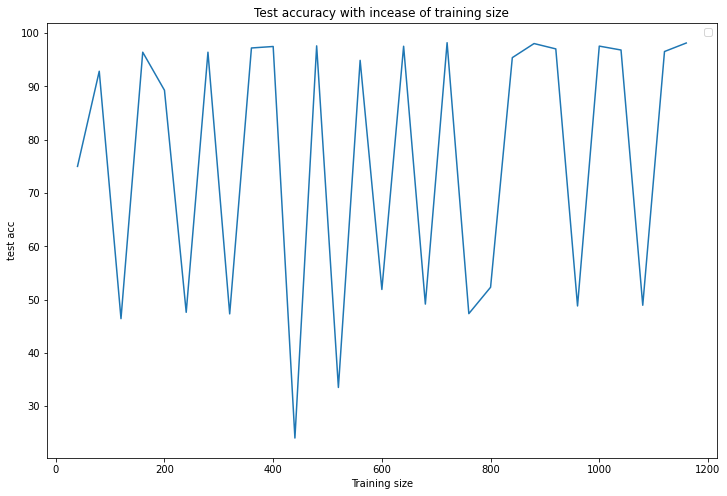

In [50]:
plt.figure(figsize=(12,8))
plt.plot(range(40,1200,40),test_acc)
plt.xlabel('Training size')
plt.ylabel('test acc')
plt.title('Test accuracy with incease of training size')
plt.legend()

In [51]:
len(range(40,8000,00))

20

# Train with image augmentation

In [66]:
test_acc = []
for i in range(40,8000,400:
  # correponding to train size  = 40-1200
  criterion = nn.CrossEntropyLoss()
  batch_size = int((i) * 0.3 // 10)
  cur_train = left_data.sample(frac=1).reset_index(drop=True)[:i]
  # image augmentation
  for i in tqdm(range(train_x.shape[0])):
    cur_train.append(train_x[i])
    cur_train.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    cur_train.append(np.fliplr(train_x[i]))
    cur_train.append(np.flipud(train_x[i]))
    cur_train.append(random_noise(train_x[i],var=0.2**2))
    for j in range(5):
        cur_train.append(train_y[i])
  train_dataset = Arthopod_Dataset(cur_train,BASE_PATH,transform)
  test_dataset = Arthopod_Dataset(test_data,BASE_PATH,transform)
  dataset_size = len(cur_train)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                            sampler=train_sampler)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                  sampler=valid_sampler)
  

  model = Net()
  train_acc,val_acc = train_model(10,0.001,0,model)
  total_t=0
  correct_t=0
  for batch_idx, (data_t, target_t) in enumerate(train_loader):
    outputs_t = model(data_t)
    loss_t = criterion(outputs_t, target_t)
    _,pred_t = torch.max(outputs_t, dim=1)
    correct_t += torch.sum(pred_t==target_t).item()
    total_t += target_t.size(0)
  test_acc.append((100 * correct_t / total_t))

------------Epoch [1/10]----------- Loss: 2.1089
------------Epoch [1/10]----------- Loss: 1.5076

train loss: 1.6460, train acc: 42.8571
validation loss: 1.2141, validation acc: 58.3333

------------Epoch [2/10]----------- Loss: 0.0005
------------Epoch [2/10]----------- Loss: 0.0121

train loss: 1.0127, train acc: 92.8571
validation loss: 1.3805, validation acc: 33.3333

------------Epoch [3/10]----------- Loss: 0.0001
------------Epoch [3/10]----------- Loss: 0.0000

train loss: 0.7776, train acc: 89.2857
validation loss: 1.4003, validation acc: 50.0000

------------Epoch [4/10]----------- Loss: 0.1180
------------Epoch [4/10]----------- Loss: 0.0418

train loss: 0.5933, train acc: 100.0000
validation loss: 1.5302, validation acc: 25.0000

------------Epoch [5/10]----------- Loss: 0.0002
------------Epoch [5/10]----------- Loss: 0.0000

train loss: 0.4767, train acc: 100.0000
validation loss: 1.6258, validation acc: 16.6667

------------Epoch [6/10]----------- Loss: 0.0018
---------

No handles with labels found to put in legend.


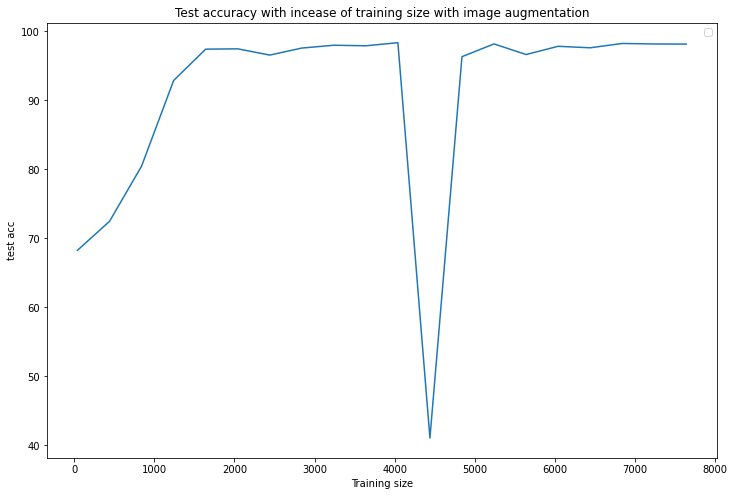

In [102]:
plt.figure(figsize=(12,8))
plt.plot(range(40,8000,400),test_acc)
plt.xlabel('Training size')
plt.ylabel('test acc')
plt.title('Test accuracy with incease of training size with image augmentation')
plt.legend()